# Starbucks Dataset Analysis

In this notebooks we analyze the data provided by Starbucks simulating customer behavior in response to offers through their mobile app. We follow CRISP-DM to analyze the data and gain insights into how customers interact with those offers. We will also answer the business questions raised in the next section

## 1. Business understanding

Starbucks regularly sends offers to different customers. Eachoffer has its own duration and condition to fulfill. Those offers fall under the following categories:
- Informational: An advertisement informing customers about a product
- BOGO: Buy one get one,  where auser needs to spend a certain amount to get a reward equal to that threshold amount
- Discount: a user gains a reward equal to a fraction of the amount spent

Through the datasets provided we will try to answer the following business questions:
1. _How did Starbucks customers engage with the different offers?_
2. _How did the offers affect or change customer behavior?_
3. _Can we predict if a customer will interact with an offer?_

## 2. Data understnding

**Note: The source of the description below comes from the provided information about the datasets**

The data that will be used is provided in the following three files:
* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [191]:
# Import packages
import pickle
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import plotly.graph_objects as go
from statsmodels.stats import weightstats as ws
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
# read the data json files
def load_datasets():
    '''
    Load the json files into pandas dataframes

        Parameters:
            None
        Returns:
            portfolio (pandas.DataFrame):
            profile (pandas.DataFrame):
            transcript (pandas.DataFrame):
    '''
    portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
    profile = pd.read_json('data/profile.json', orient='records', lines=True)
    transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
    return portfolio, profile, transcript

# Load the datasets
portfolio, profile, transcript = load_datasets()

In [209]:
# Supporting functions

def is_within_period(offer_id, elapsed_time):
    '''
    Check if a transaction is within an offer period

        Parameters:
            offer_id (object): Offer ID
            elapsed_time (int): time of the transaction
        Returns:
            is_within_period (bool): True if the transaction is within ofer period, False otherwise
    '''
    return elapsed_time < (portfolio[portfolio.id == offer_id].duration.iloc[0] * 24)

def coalesce_int(iterable):
    '''
    Similar to coalesce function in SQL, find the first that is not None nor nan and return it. Otherwise return nan

        Parameters:
            iterable (iterable): An iterable object. E.g. list
        Returns:
            value (iter item): The first value that is not None nor nan. Otherwise return nan
    '''
    for el in iterable:
        if el is not None and not np.isnan(el):
            return el
    return np.nan

def print_histogram(series, title='Histogram'):
    '''
    Display histogram for a series

        Parameters:
            series (pd.Series): A pandas series
            title (object): Histogram title 
    '''
    ax = sns.histplot(series, stat='probability')
    ax.set(ylabel='Ratio', title=title)
    plt.show()

def print_hor_perc_barplot(x, y, title, xlabel, ylabel):
    '''
    Display horizontal percentage barplot.
    Source: https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn

        Parameters:
            x (pd.Series): A pandas series of data values for x
            y (pd.Series): A pandas series of data values for y
            title (object): Plot title
            xlabel (object): X axis label
            ylabel (object): Y axis label
    '''
    plt.figure(figsize=(12,6))
    ax = sns.barplot(y=y, x=x)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.set(xlim=(0, 1))
    for p in ax.patches:
        if p.get_width() == 0:
            continue
        percentage = '{:.1f}%'.format(p.get_width()*100)
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), ha='center')
    plt.show()

def plot_sankey(offer_name, aggregated_offers_trx_details):
    '''
    Display a sankey diagram for a certain offer.
    Source: https://plotly.com/python/sankey-diagram/

        Parameters:
            offer_name (object): The code_name of an offer
            aggregated_offers_trx_details (pd.DataFrame): A pandas dataframe containing aggregated offers transactions details
    '''
    
    # Calculate the values for each step
    total_sent = aggregated_offers_trx_details.loc[offer_name]['code_name']
    sent_viewed = aggregated_offers_trx_details.loc[offer_name]['is_viewed']
    viewed_completed = aggregated_offers_trx_details.loc[offer_name]['is_viewed_and_completed']
    sent_completed = aggregated_offers_trx_details.loc[offer_name]['is_completed'] - viewed_completed
    viewed_expired = sent_viewed - viewed_completed
    sent_expired = total_sent - sent_viewed - sent_completed
    
    # Convert values to percentages
    sent_viewed = sent_viewed / total_sent * 100
    viewed_completed = viewed_completed / total_sent * 100
    sent_completed = sent_completed / total_sent * 100
    viewed_expired = viewed_expired / total_sent * 100
    sent_expired = sent_expired / total_sent * 100
    
    # Create the sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = ["Sent: {:.0f}".format(total_sent), 
                   "Viewed: {:.1f}%".format(sent_viewed), 
                   "Completed: {:.1f}%".format(viewed_completed), 
                   'Completed not viewed: {:.1f}%'.format(sent_completed),
                   'Viewed not completed: {:.1f}%'.format(viewed_expired),
                   "Expired: {:.1f}%".format(sent_expired)],
          color = "blue"
        ),
        link = dict(
          source = [0, 0, 1, 1, 0], # indices correspond to labels
          target = [5, 1, 4, 2, 3],
          value = [sent_expired, sent_viewed, viewed_expired, viewed_completed, sent_completed]
      ))])

    fig.update_layout(title_text="Customers journey for Offer: " + offer_name, font_size=10)
    fig.show(renderer="svg")
    
def df_summary(df, n=5):
    '''
    Prints the shape, missing percentages of columns and the head of a dataframe

            Parameters:
                    df (pandas.Dataframe): The dataframe to show the summary for
    '''
    print('- Shape:')
    print(df.shape)
    print('- Missing:')
    missing = df.isna().mean()[df.isna().mean()>0]
    if missing.empty:
        print('No missing (nan) values')
    else:
        print(missing)
    display(df.head(n))

def compare_two_samples(sample1, sample2, label1='label1', label2='label2', title='Comparison'):
    '''
    Compare two independent series:
        - Display a histogram showing the two distributions
        - Display the means of both series
        - Perform z-test and display test result
    Source: https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.ztest.html?highlight=ztest#statsmodels.stats.weightstats.ztest
        Parameters:
            sample1 (pd.Series): A pandas series of data values for sample1
            sample2 (pd.Series): A pandas series of data values for sample2
            label1 (object): Axis label for sample 1
            label2 (object): Axis label for sample 2
            title (object): Plot title
    '''
    # Plot comparison histogram
    plt.figure(figsize=(12,6))
    ax = sns.histplot(sample1, label=label1)
    ax = sns.histplot(sample2, color='r', label=label2, alpha=0.3)
    ax.set(title=title)
    ax.legend(loc='upper right')
    plt.show()
    
    # Print the two means
    print('Mean for {}: {}'.format(label1, np.mean(sample1)))
    print('Mean for {}: {}'.format(label2, np.mean(sample2)))
    
    # Perform ztest
    zscore, pvalue = ws.ztest(x1=sample1, 
                              x2=sample2,
                              value=0,
                              alternative='two-sided'
                             )
    print('')
    print('Z-test result:')
    print('z-score: {}'.format(zscore))
    print('p-value: {}'.format(pvalue))
    
    # Display test result based on 0.05 confidence level
    if pvalue < 0.05:
        print('The null hypothesis H0 is REJECTED. p-value is statistically significant')
    else:
        print('The null hypothesis H0 is ACCEPTED. p-value is statistically insignificant')

### We look at the head of each of the three data failes, how they look and if there is any missing values

In [5]:
df_summary(portfolio, 10)

- Shape:
(10, 6)
- Missing:
No missing (nan) values


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


It was mentioned that missing age values where encded as 118 in the dataset. Hence, we will set those values to nan

In [6]:
# Before checking percentage of missing values, as documented,
# for age replace 118, which means missing values, with nan
profile.loc[profile.age==118, 'age'] = np.nan
df_summary(profile)

- Shape:
(17000, 5)
- Missing:
gender    0.127941
age       0.127941
income    0.127941
dtype: float64


,gender,age,id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
df_summary(transcript)

- Shape:
(306534, 4)
- Missing:
No missing (nan) values


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Only profile dataset contains missing values. We can see that around 12.8% of demographics data is missing. We will decide how to handle this as we have a further look at the data

## 3. Data preparation and exploration
In this section we will perform the following data processing steps on each dataset:

### a. "portfolio" dataset
The portfolio data is quite straight forward having only 10 rows corresponding to the 10 offers.

We do some basic feature engineering. This makes it easier for any modelling step later on

In [8]:
def prepare_portfolio_dataset(portfolio): 
    '''
    Perform data preparation on portfolio dataset:
    - One-hot-encode channels
    - One-hot-encode offers
    - Give code names for offers for easier readability

        Parameters:
            portfolio (pd.DataFrame): Portfolio dataframe to be processed
        Returns:
            portfolio (pd.DataFrame): Portfolio dataframe after processing
    '''
    # Split channels column to multiple columns with one-hot-encoding
    portfolio['web_ch'] = [1 if 'web' in w else 0 for w in portfolio.channels]
    portfolio['email_ch'] = [1 if 'email' in w else 0 for w in portfolio.channels]
    portfolio['mobile_ch'] = [1 if 'mobile' in w else 0 for w in portfolio.channels]
    portfolio['social_ch'] = [1 if 'social' in w else 0 for w in portfolio.channels]

    # Also one-hot-encode offer_type
    portfolio = pd.concat([portfolio, pd.get_dummies(portfolio.offer_type)], axis=1)
    portfolio = portfolio.drop(['channels', 'offer_type'], axis=1)

    # Finally give code_name to the offers for easier readability
    portfolio['code_name'] = ['bogo_1', 'bogo_2', 'info_1', 'bogo_3', 'discount_1', 'discount_2', 'discount_3', 'info_2', 'bogo_4', 'discount_4']
    return portfolio

# Prepare portfolio dataset
portfolio = prepare_portfolio_dataset(portfolio)
portfolio.head(10)

,reward,difficulty,duration,id,web_ch,email_ch,mobile_ch,social_ch,bogo,discount,informational,code_name
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0,bogo_1
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,bogo_2
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1,info_1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0,bogo_3
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0,discount_1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0,discount_2
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0,discount_3
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1,info_2
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,bogo_4
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0,discount_4


In [9]:
# Look at the how each channel was used
portfolio[['web_ch', 'email_ch', 'mobile_ch', 'social_ch', 'bogo', 'discount', 'informational']].sum()

web_ch            8
email_ch         10
mobile_ch         9
social_ch         6
bogo              4
discount          4
informational     2
dtype: int64

We can see that email channel is used with all offers, so it loses value in terms of modelling, because it does not carry any discriminatory value! 

This should not be confused with the potential importance of it as a channel, but again not for modelling purposes

In [10]:
portfolio[['bogo', 'discount', 'informational']].sum()

bogo             4
discount         4
informational    2
dtype: int64

Clearly we have 4 bogo, 4 discount offers, and 2 informational

### b. "profile" dataset

First, we will perform the following two steps:
- Convert 'became_member_on' to datetime
- Replace 'became_member_on' with 'year_of_membership'
- Replace missing gender values with 'U' for unknown

In [188]:
def prepare_profile_dataset(profile):
    '''
    Perform data preparation on profile dataset:
    - Convert 'became_member_on' to datetime
    - Replace 'became_member_on' with 'year_of_membership'
    - Replace missing gender values with 'U' for unknown

        Parameters:
            profile (pd.DataFrame): Profile dataframe to be processed
        Returns:
            profile (pd.DataFrame): Profile dataframe after processing
    '''
    # Set date column as date
    profile.became_member_on = pd.to_datetime(profile.became_member_on.astype('str'))

    # Convert became_member_on to year_of_membership starting from 1 for 
    # subscriptions starting in end of July 2017, given that the max date is end of July 2018
    profile['year_of_membership'] = np.int32(np.ceil((np.datetime64('2018-07-30') - profile.became_member_on)/np.timedelta64(1, 'Y')))
    profile = profile.drop(['became_member_on'], axis=1)

    # Replace gender nan values with 'U'
    profile.gender = profile.gender.fillna('U')
    return profile

# Prepare profile dataset
profile = prepare_profile_dataset(profile)

AttributeError: 'DataFrame' object has no attribute 'became_member_on'

#### Looking at the dstribution of each column, and seeing if there are outliers within the data

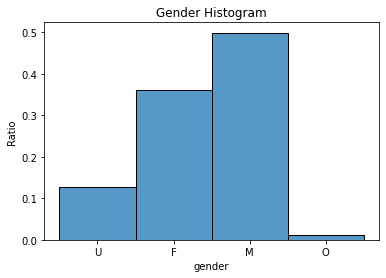

In [12]:
# Creating gender histogram
print_histogram(profile.gender, title='Gender Histogram')

We will decide what to do with the missing values denoted as 'U' later on. 
However, looking at M and F values, there is some imbalance, but it is not severe. However we will have to be careful when splitting the data and modelling

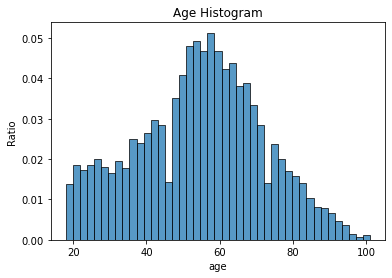

In [13]:
# Age histogram ignoring missing values
print_histogram(profile.age, title='Age Histogram')

The data seems to be normally distributed with some skewness. One reason is that the application contains ages starting from 18 years old

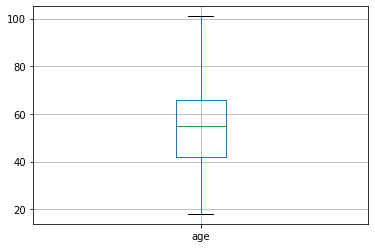

In [14]:
# Age boxplot
h = profile.boxplot(['age'], showfliers=True, return_type='dict')

We don't see any extreme valus or severe skewness other than slight skewness to the right. 
Also, from the above boxplot, we can see that 50% of our customers fall between ages around 42 and 65

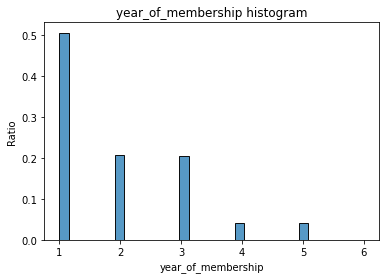

In [15]:
# Histogram for our newly created feature 'year_of_membership'
# h = profile.year_of_membership.hist()
print_histogram(profile.year_of_membership, title='year_of_membership histogram')

We can see that 50% of customers are in their first year of membership. 40% are in their 2nd or 3rd year

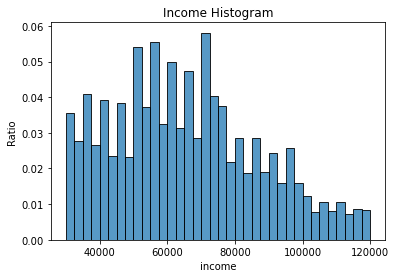

In [16]:
# Income histogram ignoring nan values
print_histogram(profile.income, title='Income Histogram')

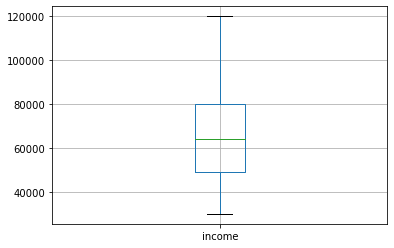

In [17]:
# Income boxplot
h = profile.boxplot(['income'], showfliers=True, return_type='dict')

Again here we don't outliers and there is some skewness slightly to the right. 50% of customers have an income between 50k to 80k

Now, we can start looking at the correlation matrix for profile features

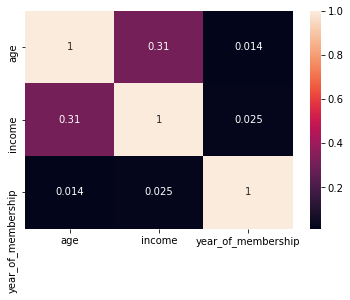

In [18]:
# Display correlation heatmap
sns.heatmap(profile.corr(), annot=True)
plt.show()

The correlation heatmap suggests some positive correlation between age and income, which is expected and can be seen better in the next set of charts. However, neither age nor income show correlation with year_of_membership feature.

Then we look at the scatterplot matrix to gain further insights

C:\Users\alien\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\alien\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


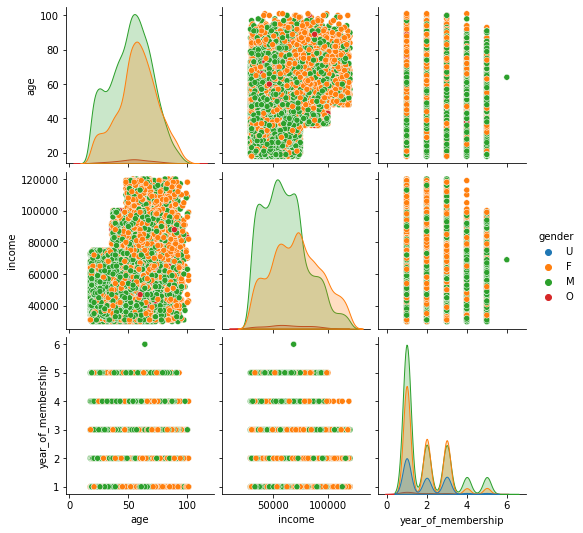

In [19]:
# For visual representation and to examine missing values, we will set missing gender values to 'U'
profile_gender_modified = profile
profile_gender_modified.gender = profile_gender_modified.gender.fillna('U')

# Create scatterplot matrix to observe distribution and interactios of different features
sns.pairplot(profile_gender_modified, hue='gender')
plt.show()

Given the charts above, I have the following comments:
- The age vs income charts show a positive correlation. However, clearly it shows how synthetic this dataset is. As in real life we won't have those clear borders.
- Male income is right skewed
- For higher incomes, it seems that female customers or more prominent
- There is nothing much noticeable regarding O and null gender records distributions. Therefore, we will drop records with nan value for demographic info

##### As mentioned, removing customer records with missing data. However, better way to do it is to check specifically the distribution of those records with missing values vs with non-missing values and see if there is any statistical significance in the difference between the two

In [20]:
# Remove rows with missing values
profile = profile.dropna()

## c. "transcript" dataset
This is where the bulk of the preprocessing work will be done as we are deling with the transactions

First we do some initial preprocessing steps by replacing 'amount' column and creating 3 columns: offer_id, amount, reward

In [21]:
def prepare_transcript_dataset(transcript):
    '''
    Perform data preparation on transcript dataset:
    - Convert the value column into 3 corresponding columns
    - Drop value column

        Parameters:
            transcript (pd.DataFrame): Transcript dataframe to be processed
        Returns:
            transcript (pd.DataFrame): Transcript dataframe after processing
    '''
    transcript['offer_id'] = [w['offer id'] if 'offer id' in w else 
                              w['offer_id'] if 'offer_id' in w else 
                              np.nan for w in transcript.value]
    transcript['amount'] = [w['amount'] if 'amount' in w else np.nan for w in transcript.value]
    transcript['reward'] = [w['reward'] if 'reward' in w else np.nan for w in transcript.value]
    transcript = transcript.drop(['value'], axis=1)
    return transcript

transcript = prepare_transcript_dataset(transcript)

#### Looking at the dstribution of each column, and seeing if there are outliers within the data

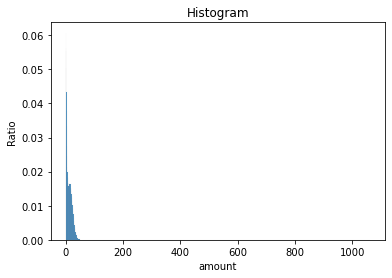

In [22]:
# Starting with transaction amounts
print_histogram(transcript[transcript.event == 'transaction'].amount)

The shape of this histogram suggests that we have some extreme values. Therefore, we will create a boxplot

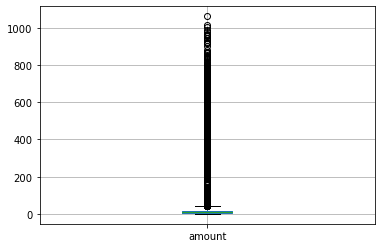

In [23]:
# Show boxplot with outliers
transcript[transcript.event == 'transaction'].boxplot(['amount'], return_type='dict')
plt.show()

We can clearly see that there are extreme values in the data.

Having another look without those extreme values:

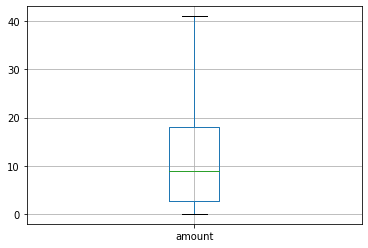

In [24]:
# Show boxplot without outliers
transcript[transcript.event == 'transaction'].boxplot(['amount'], return_type='dict', showfliers=False)
plt.show()

In [25]:
# Let's see how many transactions are with amount value above 45 let's say
# number of transactions set as outliers, check with 45 as amount
transcript[transcript.amount > 45].amount.count()

863

Given the small number of transactions, 863 out of 306534, we will drop those transactions

In [26]:
transcript = pd.concat([transcript[transcript.amount <= 45], transcript[transcript.amount.isna()]])

count    138090.000000
mean         11.182865
std           9.538444
min           0.050000
25%           2.750000
50%           8.780000
75%          17.880000
max          44.970000
Name: amount, dtype: float64


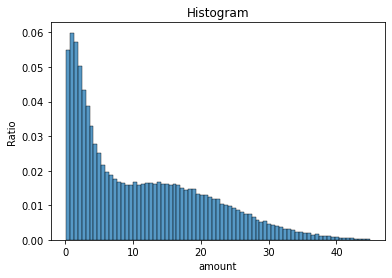

In [27]:
# Now we have another look at the histogram 
print(transcript[transcript.event == 'transaction'].amount.describe())
print_histogram(transcript[transcript.event == 'transaction'].amount)

This diagram has an interesting shape. I believe it is mostly due to the pricing of items at Starbucks, and the bump in the chart could be attributed to combination of items purchased. To confirm or refute some pricing data would be required.

## 4. Data Analysis, modelling, and evaluation
In this section we will analyze the data in order to answer the different business questions that were posed earlier. However, before we get to the questions one by one, we will need to process transcript data to identify how customers interact with the offers, and how offers affect customer behavior.

The logic in the following function produces two main data frames, and 5 other data frames containing raw transaction metrics:
1. __offers_trx_details:__ This DataFrame is concerned with offers, how users interact with them, and the transactions that we assume are associated with them, as follows:
    - For all offers received we calculate how long it took to view the offer and how long to complete if applicable
    - For each person for each offer (bogo or discount) we get all the transactions that happened between offer reception and completion. For those specific transactions we calculate avg time between transactions, mean transaction amount, and how many
    - For informational offers we calculate the time from last transaction before the offer was viewed to the first transaction after the offer is viewed
2. __normal_trx_details:__ Those are transactions that took place outside the conditions outlined above. So they do not fall between an offer view and completion
3. __raw_within_offer_trx_amounts:__ individual transaction amounts that took place during an offer
4. __raw_within_offer_trx_durations:__ duration between consecutive transactions during an offer
5. __raw_first_trx_from_last_durations:__ the duration between first commited transaction after receiving an information offer and last transaction
6. __raw_without_offer_trx_amounts:__ individual transaction amounts that took place outside any offer
7. __raw_without_offer_trx_durations:__ duration between consecutive transactions that took place outside offers

In [28]:
def process_transactions(transcript, profile, force_calc=False):
    '''
    Process transaction to identify which ones are associated to offers 
    and which are transaction that happened outside an offer. 
    
    The function looks at two main metrics (amount and duration).
    
    If the data has already been preprocssed it will be loaded. 
    Otherwise it will be processed again. If force_calc is set to True it will process anyway

        Parameters:
            transcript (pd.DataFrame): Transcript dataframe 
            profile (pd.DataFrame): Profile dataframe 
        Returns:
            raw_within_offer_trx_amounts (pd.DataFrame): individual transaction amounts that took place during an offer
            raw_within_offer_trx_durations (pd.DataFrame): duration between consecutive transactions during an offer
            raw_first_trx_from_last_durations (pd.DataFrame): the duration between first commited transaction after receiving an information offer and last transaction
            raw_without_offer_trx_amounts (pd.DataFrame): individual transaction amounts that took place outside any offer
            raw_without_offer_trx_durations (pd.DataFrame): duration between consecutive transactions that took place outside offers
    '''
    
    # If force_calc is not set try to load data from preprocessed files. 
    # If the data is not there, the data will be processed again
    if not force_calc:
        try:
            offers_trx_details = pd.read_pickle('./offers_trx_details.pkl')
            non_offers_trx_details = pd.read_pickle('./non_offers_trx_details.pkl')
            raw_within_offer_trx_amounts = pd.read_pickle('./raw_within_offer_trx_amounts.pkl')
            raw_within_offer_trx_durations = pd.read_pickle('./raw_within_offer_trx_durations.pkl')
            raw_first_trx_from_last_durations = pd.read_pickle('./raw_first_trx_from_last_durations.pkl')
            raw_without_offer_trx_amounts = pd.read_pickle('./raw_without_offer_trx_amounts.pkl')
            raw_without_offer_trx_durations = pd.read_pickle('./raw_without_offer_trx_durations.pkl')
            offers_trx_details.trx_count = [np.nan if w == 0 else w for w in offers_trx_details.trx_count]
            return (offers_trx_details, 
                    non_offers_trx_details, 
                    raw_within_offer_trx_amounts, 
                    raw_within_offer_trx_durations, 
                    raw_first_trx_from_last_durations, 
                    raw_without_offer_trx_amounts, 
                    raw_without_offer_trx_durations)
        except:
            print('Could not load processed files. Starting processing:')
    
    transcript = transcript.sort_index()
    
    # Defining required dataframes
    offers_trx_details = pd.DataFrame({'person_id': pd.Series([], dtype='str'), 
                                       'offer_id': pd.Series([], dtype='str'), 
                                       'viewed_time': pd.Series([], dtype='int'), 
                                       'completed_time': pd.Series([], dtype='int'), 
                                       'first_trx_time_from_last_trx': pd.Series([], dtype='int'),
                                       'trx_count': pd.Series([], dtype='int'), 
                                       'avg_trx_amount': pd.Series([], dtype='float'),
                                       'avg_time_btwn_trx': pd.Series([], dtype='float')
                                      })
    non_offers_trx_details = pd.DataFrame({'person_id': pd.Series([], dtype='str'), 
                                           'trx_count': pd.Series([], dtype='int'), 
                                           'avg_trx_amount': pd.Series([], dtype='float'), 
                                           'avg_time_btwn_consec_trx': pd.Series([], dtype='float')
                                          })
    
    raw_within_offer_trx_amounts = pd.DataFrame({'person_id': pd.Series([], dtype='str'), 
                                                 'offer_id': pd.Series([], dtype='str'), 
                                                 'trx_amount': pd.Series([], dtype='float')
                                                })
    raw_within_offer_trx_durations = pd.DataFrame({'person_id': pd.Series([], dtype='str'), 
                                                   'offer_id': pd.Series([], dtype='str'), 
                                                   'trx_duration': pd.Series([], dtype='float')
                                                  })
    raw_first_trx_from_last_durations = pd.DataFrame({'person_id': pd.Series([], dtype='str'), 
                                                      'offer_id': pd.Series([], dtype='str'), 
                                                      'trx_duration': pd.Series([], dtype='float')
                                                     })
    raw_without_offer_trx_amounts = pd.DataFrame({'person_id': pd.Series([], dtype='str'), 
                                                  'trx_amount': pd.Series([], dtype='float')
                                                 })
    raw_without_offer_trx_durations = pd.DataFrame({'person_id': pd.Series([], dtype='str'), 
                                                    'trx_duration': pd.Series([], dtype='float')
                                                   })
    
    # Go through person by person
    for person in tqdm(profile.id):
        # Get all transaction per person
        pt = transcript[transcript.person == person]
        
        # Flags to be used when we start checking if offers were received or viewed 
        is_offer_received = False
        is_offer_viewed = False

        # Go through all customer transactions and find offers events and transactions
        received_offers = {}
        viewed_offers = {}
        completed_offers = {}
        transactions = {}
        excluded_transactions= []
        for i in range(pt.shape[0]):
            t = pt.iloc[i]
            if t.event == 'offer received':
                received_offers[t.name] = t
            elif t.event == 'offer viewed':
                viewed_offers[t.name] = t
            elif t.event == 'offer completed':
                completed_offers[t.name] = t
            elif t.event == 'transaction':
                transactions[t.name] = t
        
        # Go through received offers one by one
        for offer_index in received_offers:
            offer_id = received_offers[offer_index].offer_id
            offer_time = received_offers[offer_index].time
            next_same_offer_index = None

            # Find the next offer with the same offer_id
            for i in received_offers:
                if i > offer_index and offer_id == received_offers[i].offer_id:
                    next_same_offer_index = i

            # Has the offer been viewed?
            is_offer_viewed = False
            view_index = None
            view_time = np.nan
            for j in viewed_offers:
                if j > offer_index and offer_id == viewed_offers[j].offer_id and (next_same_offer_index is None 
                                                                                  or j < next_same_offer_index):
                    is_offer_viewed = True
                    view_index = j
                    view_time = viewed_offers[j].time
                    break

            
            # If it is an information offer skip looking for completion. however, calculate time from last trx
            # Also check if it is within promotion period
            # Also make sure that the offer has been viewed
            first_trx_time_from_last_trx = np.nan
            if is_offer_viewed:
                transaction_index = None
                previous_transaction_index = None
                first_trx_time_from_last_trx = np.nan
                for t in transactions:
                    if t >= view_index and previous_transaction_index is not None:
                        if is_within_period(offer_id, transactions[t].time - offer_time):
                            first_trx_time_from_last_trx = transactions[t].time - transactions[previous_transaction_index].time
                            excluded_transactions.append(t)
                        break
                    elif t < view_index:
                        previous_transaction_index = t

            # has the offer been completed?
            is_offer_completed = False
            completion_index = None
            completion_time = np.nan
            for k in completed_offers:
                if k > offer_index and offer_id == completed_offers[k].offer_id and (next_same_offer_index is None 
                                                                                     or k < next_same_offer_index):
                    is_offer_completed = True
                    completion_index = k
                    completion_time = completed_offers[k].time
                    break
            
            # Handle the case if the offer has been viewed after completion
            if is_offer_viewed and is_offer_completed and view_index >= completion_index:
                is_offer_viewed = False
                view_index = None
                view_time = np.nan

            # KEEP IN MIND THAT WE ARE DISCARDING THE FIRST TRANSACTIONS THAT HAPPENS AFTER INFO IF WITHIN DURATION
            # Find within offer transactions
            within_offer_trx_amounts = []
            within_offer_trx_durations = []
            prev_trx_time = None
            for t in transactions:
                if t > offer_index and is_offer_completed and t < completion_index:
                    within_offer_trx_amounts.append(transactions[t].amount)
                    if prev_trx_time is not None:
                        within_offer_trx_durations.append(transactions[t].time - prev_trx_time)
                    prev_trx_time = transactions[t].time
                    if is_offer_viewed:
                        excluded_transactions.append(t)
            
            # Extract raw within offer transactions amounts
            # raw_within_offer_trx_amounts
            temp_raw_within_offer_trx_amounts = pd.DataFrame().reindex(
                columns=raw_within_offer_trx_amounts.columns)
            temp_raw_within_offer_trx_amounts.trx_amount = within_offer_trx_amounts
            temp_raw_within_offer_trx_amounts.person_id = temp_raw_within_offer_trx_amounts.person_id.fillna(person)
            temp_raw_within_offer_trx_amounts.offer_id = temp_raw_within_offer_trx_amounts.offer_id.fillna(offer_id)
            raw_within_offer_trx_amounts = raw_within_offer_trx_amounts.append(
                temp_raw_within_offer_trx_amounts)
            
            # Extract raw within offer transactions durations
            # raw_within_offer_trx_durations
            temp_raw_within_offer_trx_durations = pd.DataFrame().reindex(
                columns=raw_within_offer_trx_durations.columns)
            temp_raw_within_offer_trx_durations.trx_duration = within_offer_trx_durations
            temp_raw_within_offer_trx_durations.person_id = temp_raw_within_offer_trx_durations.person_id.fillna(person)
            temp_raw_within_offer_trx_durations.offer_id = temp_raw_within_offer_trx_durations.offer_id.fillna(offer_id)
            raw_within_offer_trx_durations = raw_within_offer_trx_durations.append(
                temp_raw_within_offer_trx_durations)
            
            # Extract raw duration between transactions after receiving info offer
            # raw_first_trx_from_last_durations
            temp_raw_first_trx_from_last_durations = pd.DataFrame().reindex(
                columns=raw_first_trx_from_last_durations.columns)
            temp_raw_first_trx_from_last_durations.trx_duration = [first_trx_time_from_last_trx]
            temp_raw_first_trx_from_last_durations.person_id = temp_raw_first_trx_from_last_durations.person_id.fillna(person)
            temp_raw_first_trx_from_last_durations.offer_id = temp_raw_first_trx_from_last_durations.offer_id.fillna(offer_id)
            raw_first_trx_from_last_durations = raw_first_trx_from_last_durations.append(
                temp_raw_first_trx_from_last_durations)
            
            # Calculate aggregations for offers_trx_details dataframe
            within_offer_trx_amounts_count = len(within_offer_trx_amounts)
            within_offer_trx_amounts_avg = np.nan
            if within_offer_trx_amounts_count > 0:
                within_offer_trx_amounts_avg = round(np.mean(within_offer_trx_amounts), 2)
            within_offer_trx_durations_avg = np.nan
            if len(within_offer_trx_durations) > 0:
                within_offer_trx_durations_avg = round(np.mean(within_offer_trx_durations), 2)
            
            # Create row to be added to offers_trx_details
            od = {'person_id': person, 
                  'offer_id': offer_id,
                  'viewed_time': view_time-offer_time,
                  'completed_time': completion_time-coalesce_int([view_time, offer_time]),
                  'first_trx_time_from_last_trx': first_trx_time_from_last_trx,
                  'trx_count': within_offer_trx_amounts_count,
                  'avg_trx_amount': within_offer_trx_amounts_avg,
                  'avg_time_btwn_trx': within_offer_trx_durations_avg
                 }
            offers_trx_details.loc[len(offers_trx_details)] = od

        # Process all transactions that do not fall within an offer
        # Get count, average_amount, time_between_transactions
        independent_transaction_amounts = []
        time_between_transactions = []
        previous_trx = None
        for t in transactions:
            if t not in excluded_transactions:
                independent_transaction_amounts.append(transactions[t].amount)
                if previous_trx is not None:
                    time_between_transactions.append(transactions[t].time-transactions[previous_trx].time)
                previous_trx = t
            else:
                previous_trx = None
        
        # Fill raw without offer transactions amounts
        # raw_without_offer_trx_amounts
        temp_raw_without_offer_trx_amounts = pd.DataFrame().reindex(
                columns=raw_without_offer_trx_amounts.columns)
        temp_raw_without_offer_trx_amounts.trx_amount = independent_transaction_amounts
        temp_raw_without_offer_trx_amounts.person_id = temp_raw_without_offer_trx_amounts.person_id.fillna(person)
        raw_without_offer_trx_amounts = raw_without_offer_trx_amounts.append(
            temp_raw_without_offer_trx_amounts)
        
        # Fill raw without offer transactions durations
        # raw_without_offer_trx_durations
        temp_raw_without_offer_trx_durations = pd.DataFrame().reindex(
                columns=raw_without_offer_trx_durations.columns)
        temp_raw_without_offer_trx_durations.trx_duration = time_between_transactions
        temp_raw_without_offer_trx_durations.person_id = temp_raw_without_offer_trx_durations.person_id.fillna(person)
        raw_without_offer_trx_durations = raw_without_offer_trx_durations.append(
            temp_raw_without_offer_trx_durations)
        
        # 'person_id', 'trx_count', 'avg_trx_amount', 'avg_time_btwn_consec_trx'
        trx_amounts_count = len(independent_transaction_amounts)
        trx_amounts_avg = np.nan
        time_between_trx_avg = np.nan
        if trx_amounts_count > 0:
            trx_amounts_avg = round(np.mean(independent_transaction_amounts), 2)
        if len(time_between_transactions) > 0:
            time_between_trx_avg = np.mean(time_between_transactions)
        
        # Create row to be added to non_offers_trx_details
        nod = {'person_id': person, 
               'trx_count': trx_amounts_count, 
               'avg_trx_amount': trx_amounts_avg, 
               'avg_time_btwn_consec_trx': time_between_trx_avg
              }
        non_offers_trx_details.loc[len(non_offers_trx_details)] = nod
    
    offers_trx_details.trx_count = [np.nan if w == 0 else w for w in offers_trx_details.trx_count]
    
    # Once done write processed data to pickle files
    print('Saving processed transactions')
    offers_trx_details.to_pickle('./offers_trx_details.pkl')
    non_offers_trx_details.to_pickle('./non_offers_trx_details.pkl')
    raw_within_offer_trx_amounts.to_pickle('./raw_within_offer_trx_amounts.pkl')
    raw_within_offer_trx_durations.to_pickle('./raw_within_offer_trx_durations.pkl')
    raw_first_trx_from_last_durations.to_pickle('./raw_first_trx_from_last_durations.pkl')
    raw_without_offer_trx_amounts.to_pickle('./raw_without_offer_trx_amounts.pkl')
    raw_without_offer_trx_durations.to_pickle('./raw_without_offer_trx_durations.pkl')
    return (offers_trx_details, 
            non_offers_trx_details, 
            raw_within_offer_trx_amounts, 
            raw_within_offer_trx_durations, 
            raw_first_trx_from_last_durations, 
            raw_without_offer_trx_amounts, 
            raw_without_offer_trx_durations)

# Process transactions
offers_trx_details, normal_trx_details, a, b, c, d, e = process_transactions(transcript, profile, force_calc=False)
# For readability
raw_within_offer_trx_amounts = a
raw_within_offer_trx_durations = b
raw_first_trx_from_last_durations = c
raw_without_offer_trx_amounts = d
raw_without_offer_trx_durations = e

The columns description for each dataFrame is as follows:
1. offers_trx_details:
    - __person_id__: Person id
    - __offer_id__: Offer id
    - __viewed_time__: the time difference between viewing and offer and receiving it. If not viewed it would be nan
    - __completed_time__: the time difference between completing an offer and viewing it, in case it was viewed. If not, then from receiving it. If not completed it would be nan
    - __first_trx_time_from_last_trx__: the time from last transaction before the offer was viewed to the first transaction after the offer is viewed
    - __trx_count__: # of transactions between view/reception and completion
    - __avg_trx_amount__: avergae transaction amount for the aforementioned transactions
    - __avg_time_btwn_trx__: average time between transactions for the aforementioned transactions
2. normal_trx_details:
    - __person_id__: Person id
    - __trx_count__: # of transactions that are not between view/reception and completion
    - __avg_trx_amount__: avergae transaction amount for the aforementioned transactions
    - __avg_time_btwn_consec_trx__: average time between only consecutive transactions for the aforementioned transactions
    
A sample for each is shown below:

In [29]:
offers_trx_details.head()

,person_id,offer_id,viewed_time,completed_time,first_trx_time_from_last_trx,trx_count,avg_trx_amount,avg_time_btwn_trx
0,0610b486422d4921ae7d2bf64640c50b,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,120.0,NaN,1.0,23.22,NaN
1,0610b486422d4921ae7d2bf64640c50b,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.0,126.0,NaN,1.0,19.89,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,48.0,NaN,78.0,NaN,NaN,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,0.0,102.0,132.0,1.0,21.72,NaN


In [30]:
normal_trx_details.head()

,person_id,trx_count,avg_trx_amount,avg_time_btwn_consec_trx
0,0610b486422d4921ae7d2bf64640c50b,3,25.67,255.0
1,78afa995795e4d85b5d9ceeca43f5fef,4,24.50,138.0
2,e2127556f4f64592b11af22de27a7932,2,19.66,6.0
3,389bc3fa690240e798340f5a15918d5c,0,NaN,NaN
4,2eeac8d8feae4a8cad5a6af0499a211d,2,1.60,NaN


### Q1- How did Starbucks customers engage with the different offers?

For the purpose of this analysis, we will examine how the offers were sent, viewed, completed, or expired. For informational offers, there will be only two statuses sent and viewed.

We will start by creating an aggregated dataframe from 'offers_trx_details'. For each offer we will calculate the number of receipients, views, completion, or lack thereof

In [31]:
def create_aggregated_offers_trx_details(offers_trx_details):
    '''
    Create offer level aggregation for some transaction details metrics related to:
    - Vieweing counts and percentages
    - Completion counts and percentages
    - Transaction amounts
    - Duration between transactions
    
    If the data has already been preprocssed it will be loaded. 
    Otherwise it will be processed again. If force_calc is set to True it will process anyway

        Parameters:
            offers_trx_details (pd.DataFrame): Transactions within offers details dataframe 
        Returns:
            aggregated_offers_trx_details (pd.DataFrame): Per offer aggregated amounts, durations, interaction counts, and percentages
    '''
    # Adding two columns to flag if the offer was viewed and if it was completed
    offers_trx_details['is_viewed'] = ~offers_trx_details.viewed_time.isna()*1
    offers_trx_details['is_completed'] = ~offers_trx_details.completed_time.isna()*1
    offers_trx_details['is_viewed_and_completed'] = offers_trx_details['is_viewed'] * offers_trx_details['is_completed']
    
    # Merging with portfolio dataset
    offers_trx_details = offers_trx_details.merge(portfolio, left_on='offer_id', right_on='id').drop('id', axis=1)
    
    # Pivot the dataframe and create aggregations as specified
    agg_offers_trx_details = offers_trx_details.pivot_table(index='code_name', aggfunc={'code_name':'count',
                                                                                    'viewed_time':'mean',
                                                                                    'completed_time':'mean',
                                                                                    'first_trx_time_from_last_trx':'mean',
                                                                                    'trx_count':'mean',
                                                                                    'is_viewed':'sum',
                                                                                    'is_completed':'sum',
                                                                                    'is_viewed_and_completed':'sum',
                                                                                    'web_ch':'sum',
                                                                                    'email_ch':'sum',
                                                                                    'mobile_ch':'sum',
                                                                                    'social_ch':'sum',
                                                                                    'bogo':'sum',
                                                                                    'discount':'sum',
                                                                                    'informational':'sum'})
    
    # Calculate view percentage
    agg_offers_trx_details['view_perc'] = agg_offers_trx_details.is_viewed / agg_offers_trx_details.code_name
    agg_offers_trx_details['view_complete_perc'] = agg_offers_trx_details.is_viewed_and_completed / agg_offers_trx_details.code_name

    # Since we cannot take the average of averages, I will have to weigh each average with the trx count before I can
    # calculate the overall average per offer
    temp_averages_df = offers_trx_details.loc[:, ['code_name', 'trx_count', 'avg_trx_amount', 'avg_time_btwn_trx']]
    # With this trick I just need to calculate how many durations are counted to originally get 'avg_time_btwn_trx'. 
    # It will always be (trx_count-1). Hence we are deducting the logicl condition to ensure that we only deduct when 
    # the count of transactions is greater that 0
    temp_averages_df['durations_count'] = temp_averages_df.trx_count-(temp_averages_df.trx_count > 0)
    temp_averages_df['total_trx_durations'] = temp_averages_df.durations_count * temp_averages_df.avg_time_btwn_trx
    temp_averages_df['total_trx_amounts'] = temp_averages_df.trx_count * temp_averages_df.avg_trx_amount
    averages_df = pd.DataFrame(temp_averages_df.groupby('code_name').total_trx_durations.sum()/
                               temp_averages_df.groupby('code_name').durations_count.sum(), columns=['avg_trx_time'])
    averages_df['avg_trx_amount'] = temp_averages_df.groupby('code_name').total_trx_amounts.sum()/temp_averages_df.groupby('code_name').trx_count.sum()
    
    return agg_offers_trx_details.merge(averages_df, left_index=True, right_on='code_name')

# Create aggregated_offers_trx_details
aggregated_offers_trx_details = create_aggregated_offers_trx_details(offers_trx_details)

Now we create a bunch of charts to look at the different metrics mentioned above:

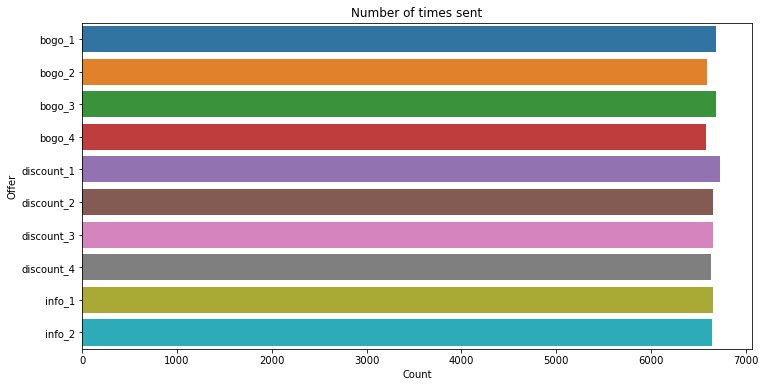

In [32]:
# Show barplot for number of times each offer is sent
plt.figure(figsize=(12,6))
ax = sns.barplot(y=aggregated_offers_trx_details.index.values, x=aggregated_offers_trx_details.code_name)
ax.set(xlabel='Count', ylabel='Offer', title='Number of times sent')
plt.show()

Clearly the offers are sent almost equal number of times. That makes our life easier

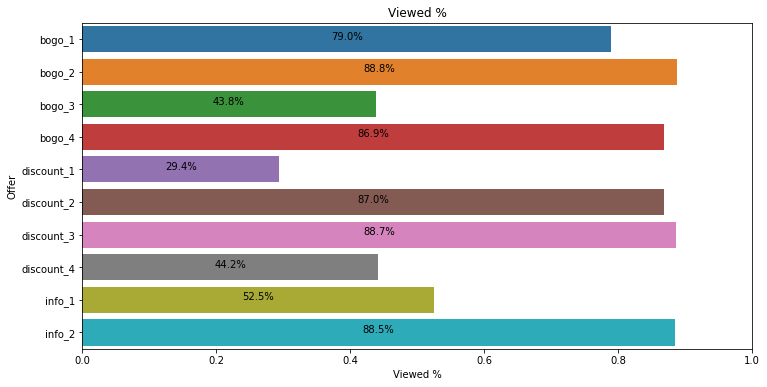

In [33]:
# Display barplot for viewing % for each offer
print_hor_perc_barplot(x=aggregated_offers_trx_details.view_perc,
                       y=aggregated_offers_trx_details.index.values,
                       title='Viewed %', xlabel='Viewed %', ylabel='Offer'
                      )

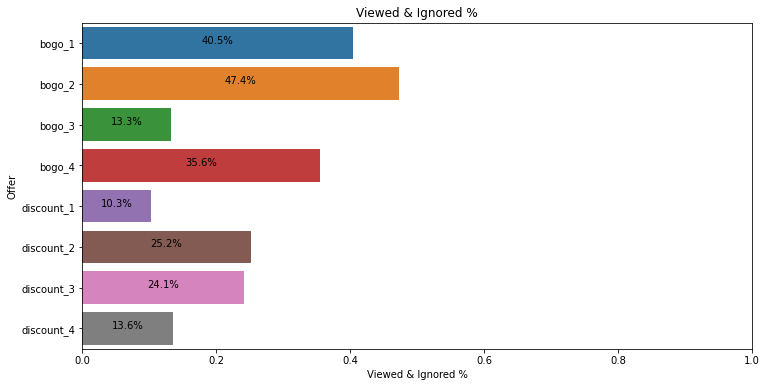

In [34]:
# Display barplot for the percentage of those who viewed and did not complete the offer
print_hor_perc_barplot(x=((aggregated_offers_trx_details.is_viewed - aggregated_offers_trx_details.is_viewed_and_completed)/aggregated_offers_trx_details.code_name)[:8],
                       y=aggregated_offers_trx_details.index.values[:8],
                       title='Viewed & Ignored %', xlabel='Viewed & Ignored %', ylabel='Offer'
                      )

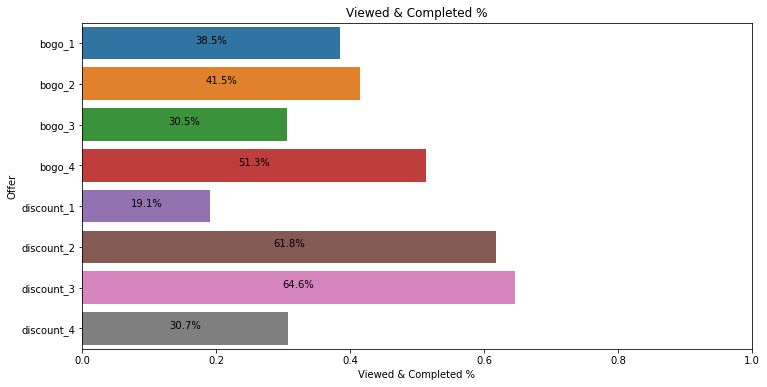

In [35]:
# Display barplot for the percentage of those who viewed and completed the offer
print_hor_perc_barplot(x=aggregated_offers_trx_details.view_complete_perc[:8],
                       y=aggregated_offers_trx_details.index.values[:8],
                       title='Viewed & Completed %', xlabel='Viewed & Completed %', ylabel='Offer'
                      )

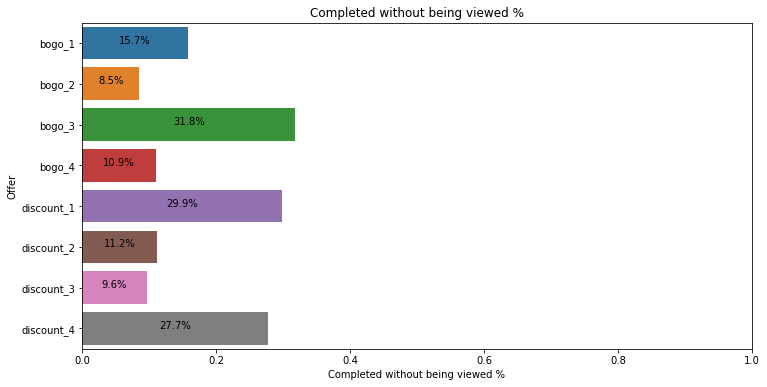

In [36]:
# Display barplot for the percentage of those who completed the offer unntentionally (without viewing it )
print_hor_perc_barplot(x=((aggregated_offers_trx_details.is_completed-aggregated_offers_trx_details.is_viewed_and_completed)/aggregated_offers_trx_details.code_name)[:8],
                       y=aggregated_offers_trx_details.index.values[:8],
                       title='Completed without being viewed %',
                       xlabel='Completed without being viewed %',
                       ylabel='Offer'
                      )

Fromt the charts above we can observe the following:
- 6 out of 10 offers were viewed by around 80% or more of customers which seems very good
- Around 30% of those who completed bogo_3, discount_1, and discount_4 did it without even viewing the offer. This means that either way customers would have continued with their purchaing habits without the business spending money on those offers. However, this cannot be concluded unless we know the motivation of this offer. It might not be purely financial, there might be loyalty aspects, or some utility function that is used to measure success of an offer
- Surprisingly, those three offers (bogo_3, discount_1, and discount_4) that were viewed the least (less than 50%), are the ones that were completed without being viewed the most. This is unclear and could be due to the way the data was synthesized or some other factors that require clarification from business, because the difficulty of those offers is above average
- The offer that seems to have done the best in terms of engagement is "discount_3". Customers seem to have engaged with it in terms of views, completion, and the relatively lower number of those who viewed it and ignored it

In the section we look at the journey of how our customers interacted with what we deem to be the best performing offer (discount_3), and one of the worst performing offers (discount_1)

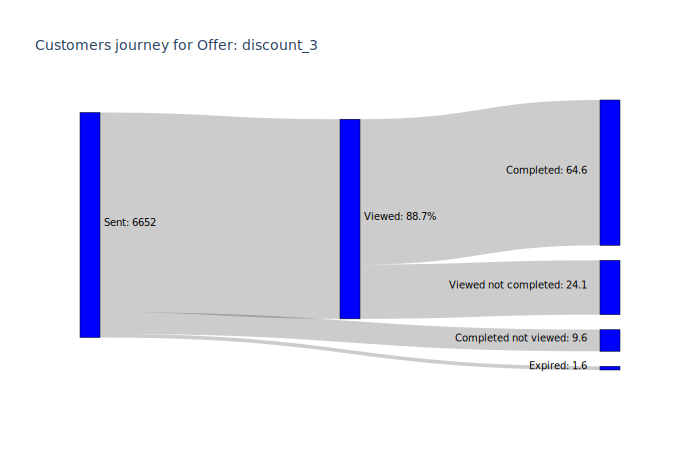

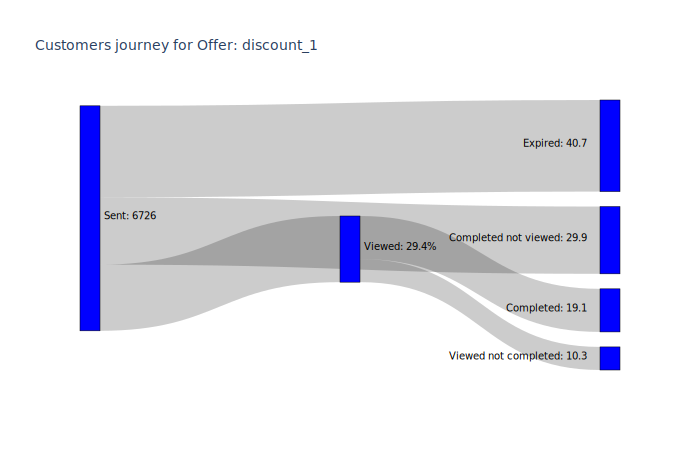

In [211]:
# Display sankey diagrams for discount_3 and discount_1
plot_sankey('discount_3', aggregated_offers_trx_details)
plot_sankey('discount_1', aggregated_offers_trx_details)

This kind of diagrams gives a very good view of how each offer is performing. Of course we can add other measures, e.g. financial

### Q2- How did the offers affect or change customer behavior?

In the first question we looked at how the offers performed in terms of customer engagement. Now, we want to measure if those offers changed the customer behavior. Of course the condition for transactions within an offer is that the offer has been viewed, and completed in the case of bogo and discount. 

We will measure this as follows:
1. For informational offers, we will check if the duration that users take to make the first purchase after the informational offer is reduced in comparison to the usual duration that customers take between consecutive purchases that are not under any offer
2. For bogo and discount offers, we will check if the duration between purchase instances for transactions within an offer is different from the duration between normal consecutive transactions that are not withi an offer period
3. Finally, we will check if the there is a statistically significant change in transaction amounts during an offer (bogo or discount) from outside an offer

Those tests will be conducted using z-test, and then we measure the statistical significance of the result. We choose z-test for the following reasons:
- We have a very large sample size
- The data points are independent from each other
- Even though ideally the samples should have a normal distribution, given the large sample size this should be accepted

##### 1. Starting with our test regarding the effect of informational offers. We set the hypotheses first:
__H0:__ The informational offer _does NOT_ have an effect on the duration customers take until their next purchase

__H1:__ The informational offer _DOES_ have an effect on the duration customers take until their net purchase

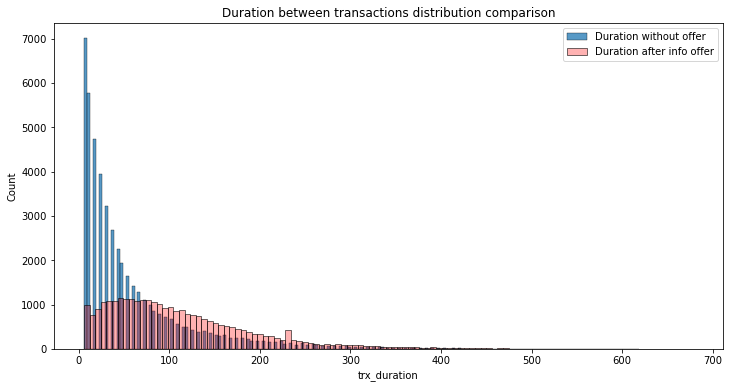

Mean for Duration without offer: 56.59837765684362
Mean for Duration after info offer: 112.20517659746562

Z-test result:
z-score: nan
p-value: nan
The null hypothesis H0 is ACCEPTED. p-value is statistically insignificant


In [41]:
compare_two_samples(raw_without_offer_trx_durations.trx_duration, 
                    raw_first_trx_from_last_durations.trx_duration,
                    label1='Duration without offer',
                    label2='Duration after info offer',
                    title='Duration between transactions distribution comparison'
                   )

Only by looking at the chart above and the mean values we can see how different the two samples are. Of course, the z-test confirms that informational offer has an effect. However, it is suprisingly counter-intuitive. Because this suggests that customers take longer time to make a purchase after receiving an informational offer in comparison to the time they usually take between transactions.

Nonetheless, this could be due to the time informational offers are beng set. E.g. late at night, or some time in the weekend. This requires further investigation with business, and complimentary data to shed more light.

##### 2. Testing the effect of BOGO and discount offers on transaction durations. We set the hypotheses:
__H0:__ The BOGO and discout offers _DO NOT_ have an effect on the duration between customer's consecutive purchase instances during an offer

__H1:__ The BOGO and discout offers _DO_ have an effect on the duration between customer's consecutive purchase instances during an offer

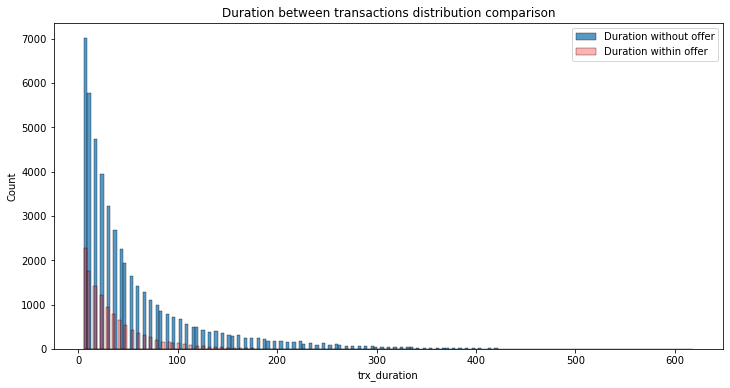

Mean for Duration without offer: 56.59837765684362
Mean for Duration within offer: 34.99188706798637

Z-test result:
z-score: 35.71007015621685
p-value: 2.7584775958939873e-279
The null hypothesis H0 is REJECTED. p-value is statistically significant


In [42]:
compare_two_samples(raw_without_offer_trx_durations.trx_duration, 
                    raw_within_offer_trx_durations.trx_duration,
                    label1='Duration without offer',
                    label2='Duration within offer',
                    title='Duration between transactions distribution comparison'
                   )

Clearly, from the mean values we see above and the ztest, during an offer customers do purchase more frequently. I.e. the duration between purchase transactions is reduced!

Of course if needed we can dig deeper to see which specific offer did best

##### 3. Testing the effect of BOGO and discount offers on transaction amounts. We set the hypotheses:
__H0:__ The BOGO and discout offers _DO NOT_ have an effect on the purchase transaction amount during an offer

__H1:__ The BOGO and discout offers _DO_ have an effect on the purchase transaction amount during an offer

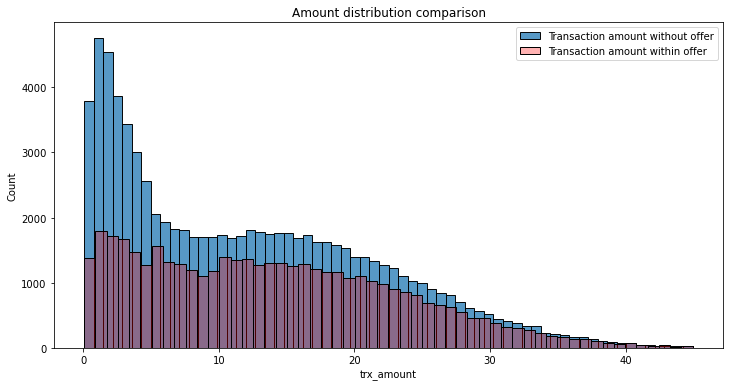

Mean for Transaction amount without offer: 12.176671561127387
Mean for Transaction amount within offer: 14.093567676493235

Z-test result:
z-score: -34.10605117681743
p-value: 5.999710750577186e-255
The null hypothesis H0 is REJECTED. p-value is statistically significant


In [43]:
compare_two_samples(raw_without_offer_trx_amounts.trx_amount, 
                    raw_within_offer_trx_amounts.trx_amount,
                    label1='Transaction amount without offer',
                    label2='Transaction amount within offer',
                    title='Amount distribution comparison'
                   )

Again, this clearly shows that during an offer customers spend more per transaction, and the amount difference is statistically significant

### Q3- Can we predict if a customer will interact with an offer? and what are the determining factors?

In [156]:
def generate_dataset(profile, portfolio, offers_trx_details, normal_trx_details):
    '''
    Generate a dataset for the predictive model. 
    The dataset will be created from combining data from:
    - profile
    - portfolio
    - normal_trx_details
    - offers_trx_details
    
    It will join the data, one-hot-encode, and remove any unnecessary data for the modelling

        Parameters:
            profile (pd.DataFrame): Profile dataset
            portfolio (pd.DataFrame): Portfolio dataset 
            normal_trx_details (pd.DataFrame): Transactions outside an offer details dataframe 
            offers_trx_details (pd.DataFrame): Transactions within offers details dataframe 
        Returns:
            prediction_dataset (pd.DataFrame): Dataset to be used for creating the model
    '''
    
    # One-hot-encode gender and merge with profile
    prediction_dataset = profile.merge(pd.get_dummies(profile.gender), 
                                       left_index=True, right_index=True)
    prediction_dataset = prediction_dataset.drop(['gender'], axis=1)
    prediction_dataset = prediction_dataset.set_index('id')
    
    # Merge with normal_trx_details and remove unnecessary columns
    normal_trx_details = normal_trx_details.set_index('person_id')
    normal_trx_details = normal_trx_details.drop(['trx_count', 'avg_time_btwn_consec_trx'], axis=1)
    prediction_dataset = prediction_dataset.merge(
        normal_trx_details, left_index=True, right_index=True)
    prediction_dataset.avg_trx_amount = prediction_dataset.avg_trx_amount.fillna(0)
    
    # Merge with offers_trx_details and remove unnecessary columns
    offers_trx_details = offers_trx_details[['person_id', 'offer_id', 'is_viewed_and_completed']]
    prediction_dataset = prediction_dataset.merge(offers_trx_details, left_index=True, right_on='person_id')
    prediction_dataset = prediction_dataset.drop(['person_id'], axis=1)
    
    # Merge with portfolio dataset and remove unnecessary columns
    prediction_dataset = prediction_dataset.merge(portfolio, left_on='offer_id', right_on='id')
    prediction_dataset = prediction_dataset[prediction_dataset.informational == 0]
    prediction_dataset = prediction_dataset.drop(['offer_id', 'id', 'code_name', 'informational'], axis=1)
    prediction_dataset = prediction_dataset.reset_index()
    prediction_dataset = prediction_dataset.drop(['index'], axis=1)
    return prediction_dataset

# Create dataset to be used to build the model
prediction_dataset = generate_dataset(profile, portfolio, offers_trx_details, normal_trx_details)

In [181]:
def build_model():
    '''
    Build a random forest classifier model and use GridSearchCV to find the best model prameters

            Returns:
                    clf (GridSearchCV): the model enveloped in the search method
    '''
    # Number of trees in random forest
    n_estimators = range(200, 500, 100)
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = range(8, 15, 2)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf
                  }

    # Define the random forest model and set it in randomized search cv
    rfc = RandomForestClassifier()
    clf = GridSearchCV(estimator = rfc, param_grid=random_grid, cv=10, verbose=2, n_jobs = -1)
    return clf

In [198]:
def display_model_metrics(y_test, y_pred, model):
    '''
    Displays the model metrics (Accuracy, F1 score), and the best performing model parameters

            Parameters:
                    y_test (pandas.Series): ground truth values
                    y_pred (pandas.Series): model predictions
                    model (RandomizedSearchCV): fit search model 
    '''
    print('Accuracy: {:0.2f}'.format(accuracy_score(y_test, y_pred)))
    print('F1 score: {:0.2f}'.format(f1_score(y_test, y_pred)))
    print('Best performing model parameters:')
    print(model.best_params_)

In [182]:
def fit_model(X_train, y_train, model):  
    try:
        loaded_model = pickle.load(open('./trained_model.pkl', 'rb'))
        return loaded_model
    except:
        print('Model not found. Fitting new model')
    
    model.fit(X_train, y_train)
    pickle.dump(model, open('./trained_model.pkl', 'wb'))
    return model

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 19.8min finished


In [197]:
# Split the data for training and testing
y = prediction_dataset.is_viewed_and_completed
X = prediction_dataset.drop(['is_viewed_and_completed'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, shuffle=True, stratify=y)

# Build and fit the model
model = build_model()
model = fit_model(X_train, y_train, model)

# Create predictions
y_pred = model.predict(X_test)

# Test model performance
display_model_metrics(y_test, y_pred, model)

Accuracy: 0.73
F1 score: 0.68
Best performing model parameters:
{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


Looking at the score, we are checking the f1-score to see if there is bias in the model due to the imbalance in labels. However, we can say that the value for both Accuracy and F1-score is very reasonable

#### Determining factors

Now we take a look at the most important features determined by the model that would give an indicator if someone will view and complete an offer or not

In [202]:
features_imp = dict(zip(X_train.columns, model.best_estimator_.feature_importances_))
top_10_features_imp = dict(sorted(features_imp.items(), key=lambda x: x[1], reverse=True)[:10])
top_10_features_imp

{'avg_trx_amount': 0.3687186618293759,
 'year_of_membership': 0.13958401034641063,
 'social_ch': 0.13052676063007346,
 'income': 0.08426681212828085,
 'age': 0.05948186677286245,
 'reward': 0.04905632047843684,
 'difficulty': 0.04426639713941295,
 'duration': 0.032765037543049186,
 'mobile_ch': 0.03011033855207945,
 'bogo': 0.01833686543681661}

We can clearly see that individual attributes are the most important features, followed by offer properties. Those features are:
- avg_trx_amount: The average spending amount per transaction of a customer
- year_of_membership: How long the customer has been a member
- social_ch: whether the offer was sent of a social media channel or not
- income: Customer's income
- age: Customer's age
- reward: The reward amount of the offer
- difficulty: Offer's difficulty
- duration: How long the offer will run for
- mobile_ch: Whether the offer was sent over the mobile channel
- If the offer is of type buy-one-get-one

Now let's look at how those features are correlated with the outcome and with each other. However, we will limit it only to 5 features for ease of visualization:

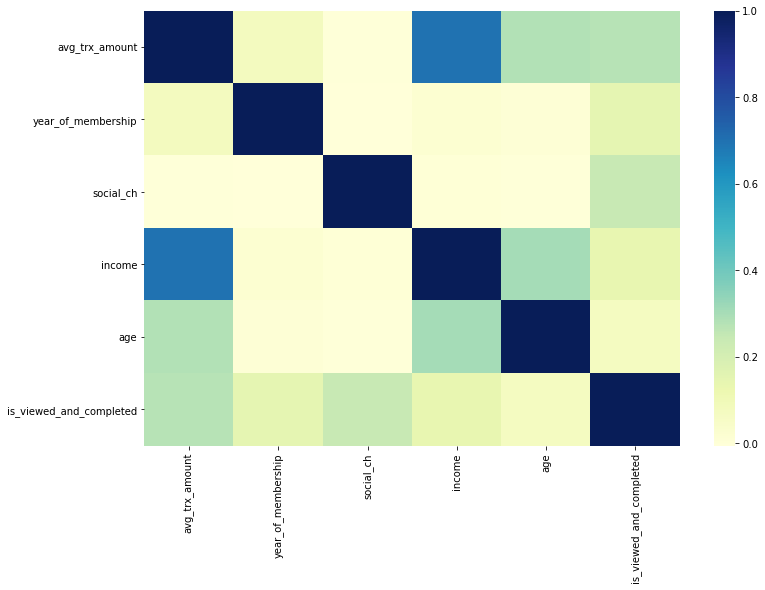

In [206]:
# Display correlation matrix for the top 5 features with outcome
fig = plt.gcf()
fig.set_size_inches(12, 8)
top_features_df = pd.concat([X_train, X_test], axis=0)[list(top_10_features_imp.keys())[:5]]
top_features_df = top_features_df.merge(pd.concat([y_train, y_test], axis=0), left_index=True, right_index=True)

sns.heatmap(pd.DataFrame.corr(top_features_df), cmap="YlGnBu")
plt.show()

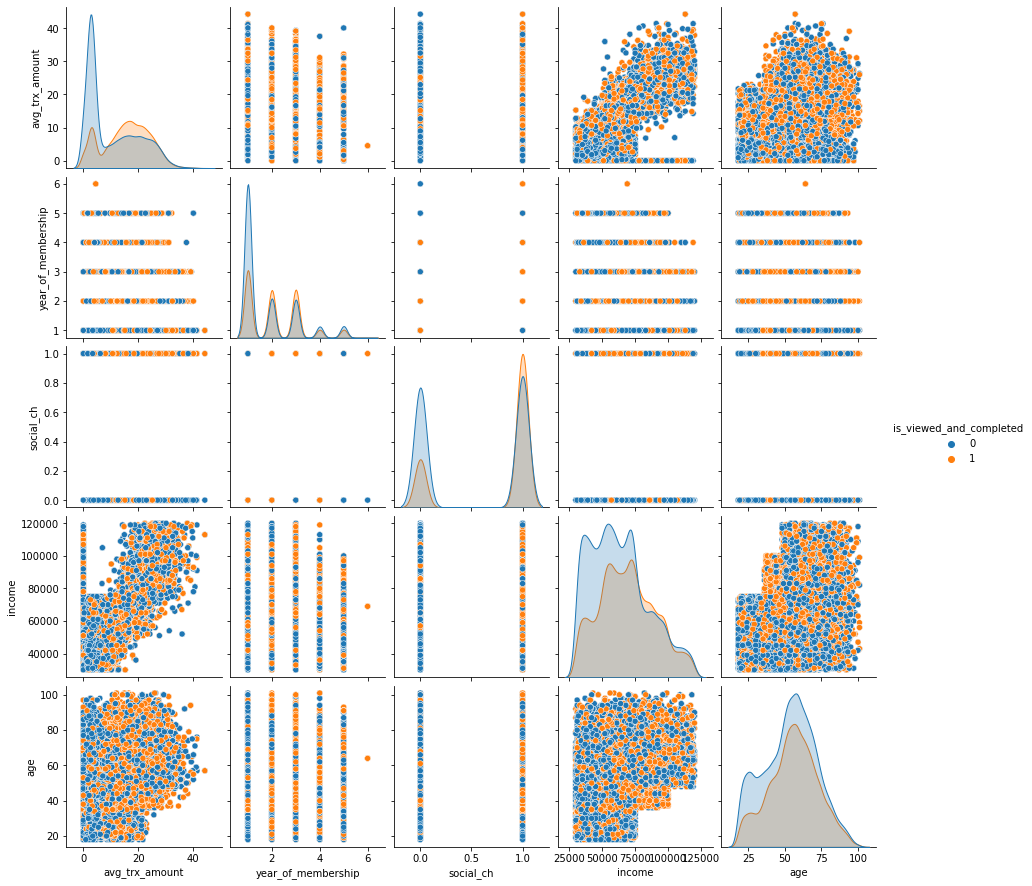

In [208]:
# Display the scatterplot matrix for the top 5 features with outcome
sns.pairplot(top_features_df, hue='is_viewed_and_completed')
plt.show()

Focusing on the diagonal charts, we can observe the following:
- Average transaction amount is positively correlated with likelihood of participating
- Years of membership that are between 2 and 3 are more positively correlted with a positive outcome. Less or more years are the other way around. Especially newer members.
- Social channel shows a positive correlation
- The higher the income the more likely someone seems to participate in an offer

## 5. Conclusion

In this exercise we analyzed the customers and offers data from Starbucks. We tried to answer the different posed business questions by following CRISP-DM.

We identified how our customers interacted with each of the offer, and the journey of customers throughout this interaction.

Then we shed some light at whether the offers has an impact on customer behavior and spending.

Finally, built a predictive model that can provide us with the likelihood of a customer participating with a certain offer or not. We also utilized this model to understand the most important features at determining whether a customer will interact with an offer.